# 8.3.1 Fitting Classification Trees

In [1]:
library(tree)

We will be using classification trees on the `Carseat` data set. We need to recode the continuous variable `Sales` as a binary.

In [2]:
library(ISLR2)
attach(Carseats)
High <- factor(ifelse(Sales <= 8, "No", "Yes"))
Carseats <- data.frame(Carseats, High)

We use the `tree()` function to fit a classification tree in order to predict `High` using all variables but `Sales`.

In [3]:
tree.carseats <- tree(High ~ . - Sales, Carseats)

In [4]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

We see that the training error rate is $9\%$. For classification trees, the deviance reported in the output of `summary()` is given by
\begin{align}
-2 \sum_m \sum_k n_{mk} \log{\hat{p}_{mk}}\mathrm{,}
\end{align}
where $n_{mk}$ is the number of observations in the $m$th terminal node that belong to the $k$th class. This is closely related to the entropy, defined in (8.7). A small deviance indicates atree that provides a good fit to the (training) data. The _residual mean deviance_ reported is simply the deviance divided by $n-|T_0|$, which in this cas is $400 - 27 = 373$.

We can display trees using the `plot()` and `text()` function.

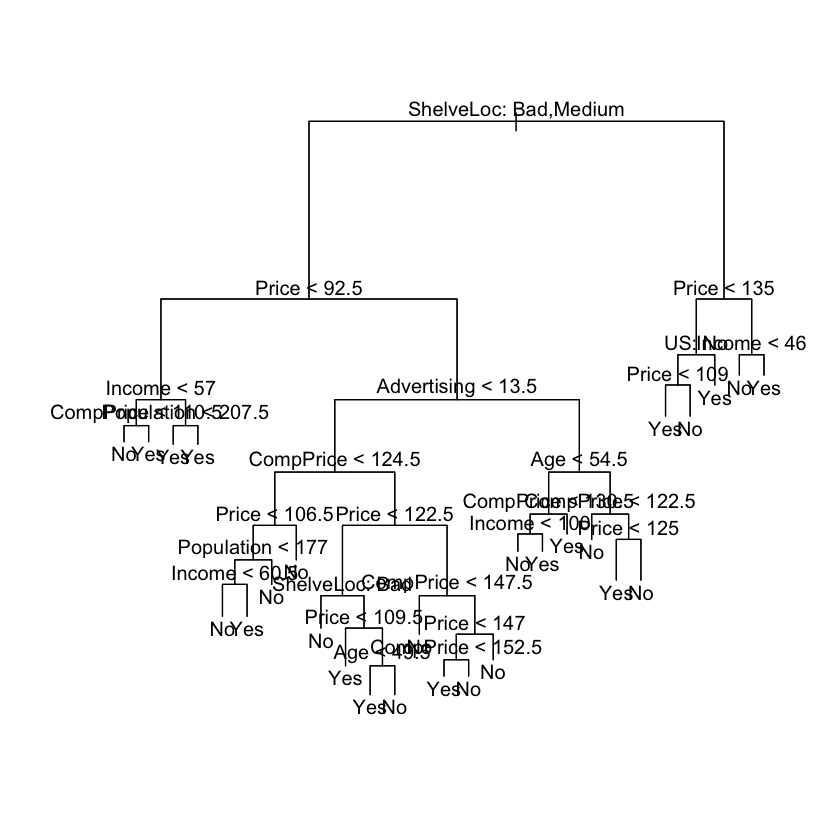

In [5]:
plot(tree.carseats)
text(tree.carseats, pretty = 0)

The most important indicator of `Sales` appears to be shelving locaion, since the first branch differentiates `Good` locations from `Bad` and `Medium` locations.

If we just type the name of the tree object, `R` prints output corresponding to each branch of the tree. `R` displays the split criterion (e.g. `Price < 92.5`), the number of observations in that branch, the deviance, the overall prediction for the branch (`Yes` or `No`), and the fraction of observations in that branch that take on values of `Yes` and `No`. Branches that lead to terminal nodes are indicated using aserisks.

In [6]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. The `predict()` function can be used for this purpose. In the case of a classification tree, the argument `type = "class"` instructs `R` to return the actual class prediction. This approach leads to correct predictions for around $77\%$ of the locations in the test data set.

In [7]:
set.seed(2)
train <- sample(1:nrow(Carseats), 200)
Carseats.test <- Carseats[-train,]
High.test <- High[-train]
tree.carseats <- tree(High ~ . - Sales, Carseats, subset = train)
tree.pred <- predict(tree.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

         High.test
tree.pred  No Yes
      No  104  33
      Yes  13  50

(If you re-run the `predict()` function then you migh get slightly different results, due to "ties": for instance, this can happen when the training observations corresponding to a terminal node are evenly split between `Yes` and `No` response values.)

Next, we consider whether pruning the tree might lead to improved results. The function `cv.tree()` performs cross-validation in order to determine the optimal level of tree complexity: cost complexity pruning is used in order to select a sequence of trees for consideration. We use the argument `FUN = prune.misclass` in order to indicate that we want the classification error rate to guide the cross-validation and pruning process, rather than the default for the `cv.tree()` function, which is deviance. The `cv.tree()` function reports the number of terminal nodes of each tree considered (`size`) as well as the corresponding error rate and the value of the cost-complexity parameter used (`k`, which corresponds to $\alpha$ in (8.4)).

In [8]:
set.seed(7)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)
names(cv.carseats)
cv.carseats

[1] "size"   "dev"    "k"      "method"

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 75 75 75 74 82 83 83 85 82

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

Dispite its name, `dev` corresponds to the number of cross-validation errors. The tree with $9$ terminal nodes results in only $74$ cross-validation errors. We plot the error rate as a function of both `size` and `k`.

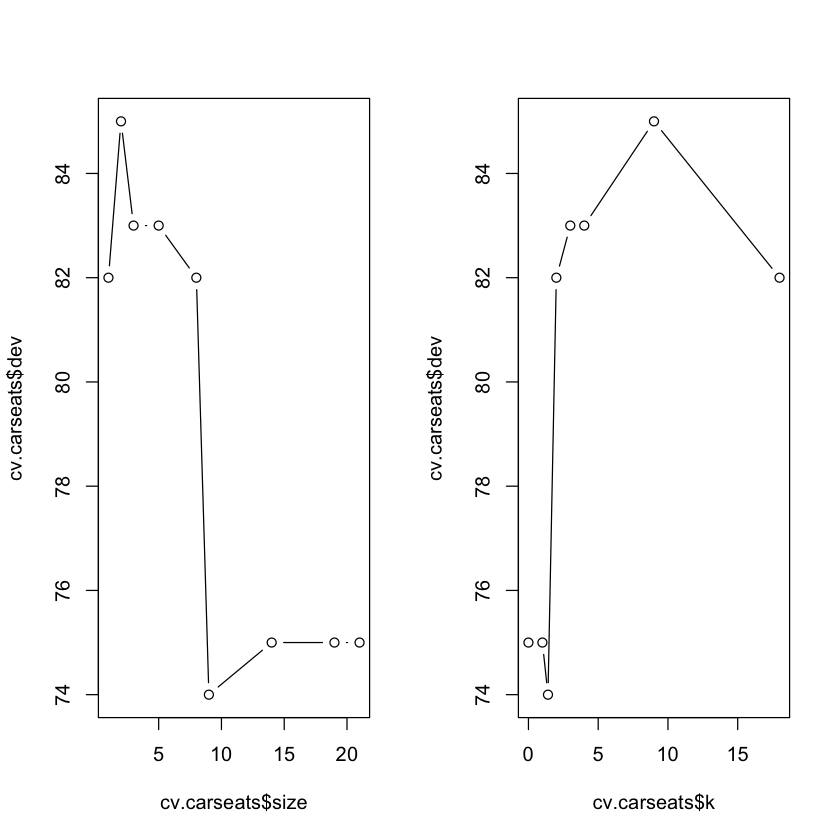

In [9]:
par(mfrow = c(1, 2))
plot(cv.carseats$size, cv.carseats$dev, type = "b")
plot(cv.carseats$k, cv.carseats$dev, type = "b")

We now apply the `prune.misclass()` function in order to prune the tree to obtain the nine-node tree.

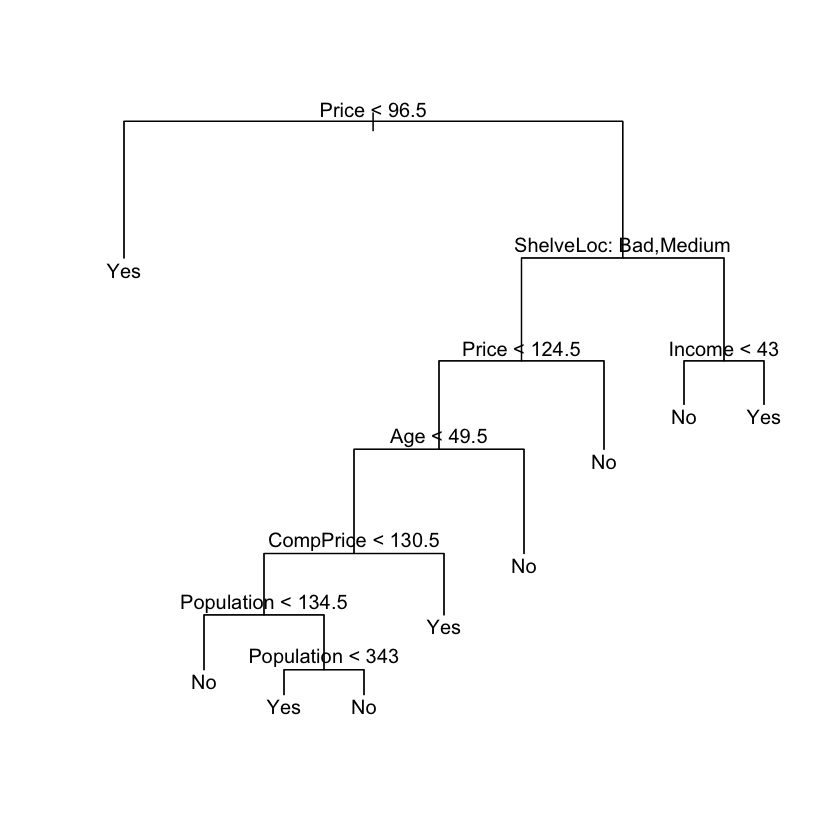

In [10]:
prune.carseats <- prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

How well does this pruned tree perform on the test data set? Once again we apply the `predict()` function.

In [11]:
tree.pred <- predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)
(97 + 58) / 200

         High.test
tree.pred No Yes
      No  97  25
      Yes 20  58

[1] 0.775

Now $77.5\%$ of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also slightly improved the classification accuracy.

If we increase the value of `best`, we obtain a larger pruned tree with lower classification accuracy:

         High.test
tree.pred  No Yes
      No  102  31
      Yes  15  52

[1] 0.77

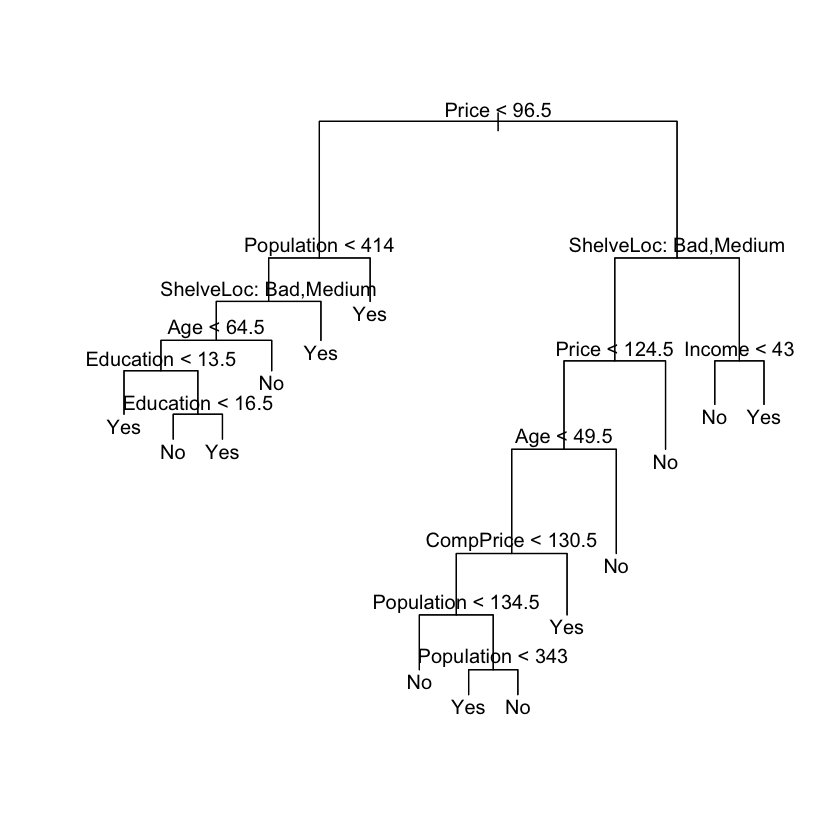

In [12]:
prune.carseats <- prune.misclass(tree.carseats, best = 14)
plot(prune.carseats)
text(prune.carseats, pretty = 0)
tree.pred <- predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)
(102 + 52) / 200